In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.5)
%matplotlib inline

from scipy.io import loadmat
from scipy.io import netcdf

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Вспышка 06.09.2017

## Данные

In [3]:
from os import listdir

In [4]:
path = './data_gnss_2017_09_06/'

files = listdir(path)
df_list = []
for file in files:
    data = loadmat(path + file)
    matr_gps = pd.DataFrame(data['Matr_GPS'])
    df_list.append(matr_gps)

In [5]:
m = pd.concat(df_list)
m.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.0,13.0,1.762345e+07,3.239511e+06,1.948358e+07,0.0,24.0,-0.000249,2.048952e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,17.0,1.443831e+07,2.235654e+07,1.645266e+06,0.0,24.0,-0.000249,2.342714e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,8.0,-1.508470e+07,4.746122e+06,2.140276e+07,0.0,24.0,-0.000249,2.428431e+07,NaN,...,NaN,9.529688e+07,NaN,8.0,-2087.311,NaN,NaN,48.25,NaN,NaN
3,0.0,28.0,9.392654e+06,1.360558e+07,2.141733e+07,0.0,24.0,-0.000249,2.056915e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,30.0,3.687572e+06,2.027251e+07,1.668516e+07,0.0,24.0,-0.000249,2.127061e+07,NaN,...,NaN,8.347046e+07,NaN,9.0,-1633.505,NaN,NaN,57.50,NaN,NaN


In [6]:
param_gps = data['Param_GPS']

for attribute in param_gps[0]:
    print('\"' + attribute[0] + '\"', end=', ')

"Time", "PRN", "X ECEF", "Y ECEF", "Z ECEF", "Flag", "N S", "Clock ofset", "C1C", "L", "S/N", "L1C", "L", "S/N", "D1C", "L", "S/N", "S1C", "L", "S/N", "C1W", "L", "S/N", "L1W", "L", "S/N", "S1W", "L", "S/N", "C2X", "L", "S/N", "L2X", "L", "S/N", "D2X", "L", "S/N", "S2X", "L", "S/N", "C2W", "L", "S/N", "L2W", "L", "S/N", "D2W", "L", "S/N", "S2W", "L", "S/N", "C5X", "L", "S/N", "L5X", "L", "S/N", "D5X", "L", "S/N", "S5X", "L", "S/N", 

In [7]:
n_x = np.where(param_gps[0] == 'X ECEF')[0][0]
n_y = np.where(param_gps[0] == 'Y ECEF')[0][0]
n_z = np.where(param_gps[0] == 'Z ECEF')[0][0]
n_x, n_y, n_z

(2, 3, 4)

In [8]:
position = np.array([data['Position_X'][0][0], data['Position_Y'][0][0], data['Position_Z'][0][0]])
x_p, y_p, z_p = position
x_p, y_p, z_p

(2901498.794, 2247627.0854, 5199076.8688)

In [9]:
x_s = m.values[:, n_x]
y_s = m.values[:, n_y]
z_s = m.values[:, n_z]

## Фазовые измерения

### Расчет угла между спутником и приемником

In [10]:
import pymap3d as pm

In [11]:
lat, lon, alt = pm.ecef2geodetic(x_p, y_p, z_p, ell=None, deg=False)
az, elev, slantRange = pm.ecef2aer(x_s, y_s, z_s, lat, lon, alt, ell=None, deg=False)
cos_a = np.sin(elev)

### Расчет ПЭС

In [12]:
n_1 = np.where(param_gps[0] == 'L1C')[0][0]
n_2 = np.where(param_gps[0] == 'L2X')[0][0] 
L_1 = m.values[:, n_1]
L_2 = m.values[:, n_2]

f1 = 1.57542 * 1e9
f2 = 1.2276 * 1e9
c = 3e8
lambda_1 = c / f1
lambda_2 = c / f2

In [13]:
TEC_p = ((f1**2 * f2**2) / (f1**2 - f2**2) / (40.308)) * (L_1*lambda_1 - L_2*lambda_2)
TECU = TEC_p / 1e16

TEC_p_normal = TEC_p * cos_a
TECU_normal = TEC_p_normal / 1e16

needed_sats = [8, 10, 15, 27, 32]

## Измерения для всех спутников

In [14]:
from phase_measurements import satellite_calculations

In [15]:
t_start = 42000
t_end = 45000
t_an_start = 43000
t_an_end = 45000

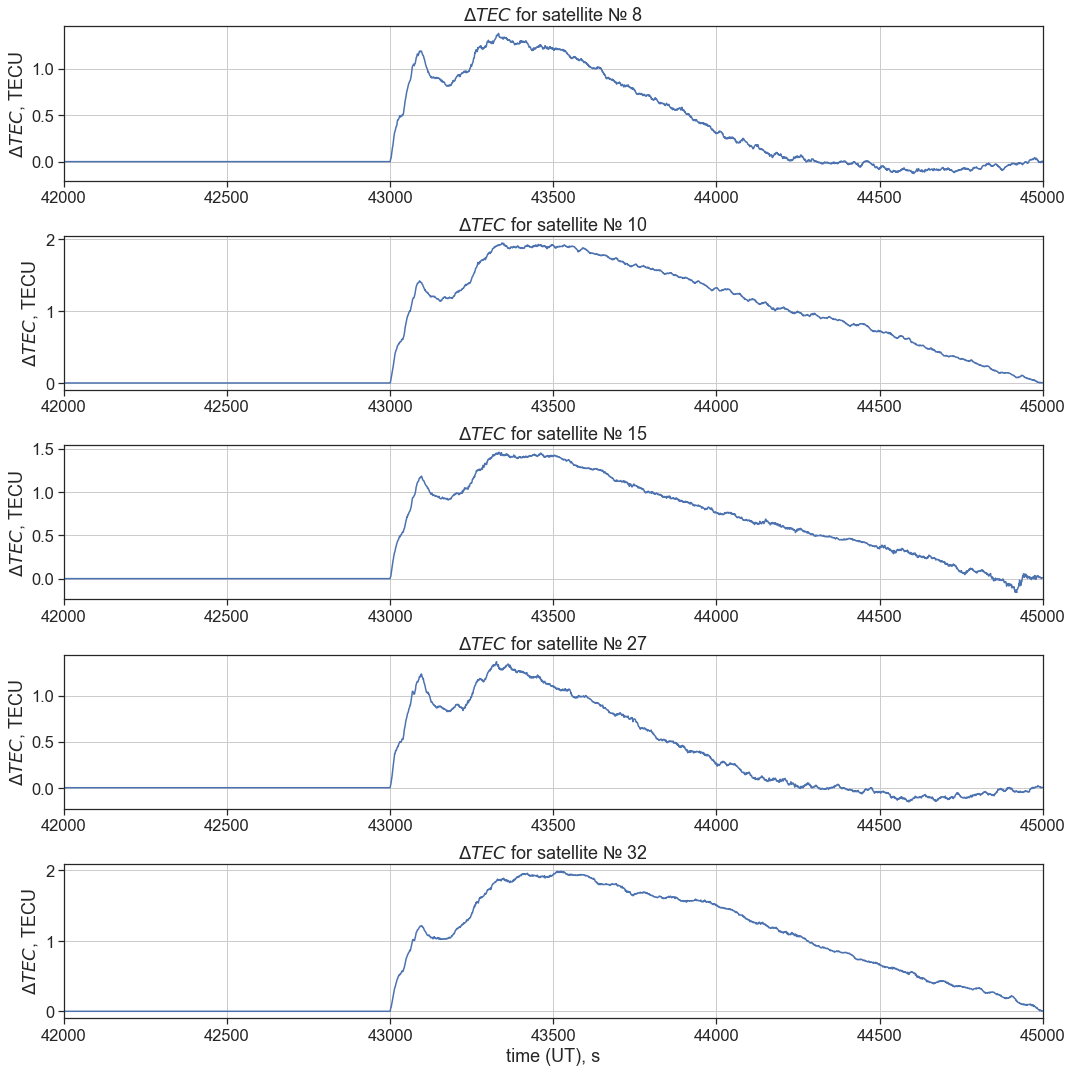

In [16]:
sat_numbers = [8, 10, 15, 27, 32]

other_params = [t_start, t_end, t_an_start, t_an_end, m, TECU_normal]

plt.figure(figsize=(15, 15))

results = []

for i in range(len(sat_numbers)):

    
    x, y = satellite_calculations(sat_numbers[i], other_params)
    results.append(y)

    plt.subplot(len(sat_numbers), 1, i+1)  
    plt.plot(x, y)
    plt.xlim(t_start, t_end)
    plt.title(r'$\Delta TEC$ for satellite № ' + f'{sat_numbers[i]}')
    plt.ylabel(r'$\Delta TEC$, TECU')
    if i == len(sat_numbers) - 1:
        plt.xlabel('time (UT), s')
    plt.grid()

plt.tight_layout()
results = np.array(results)

**Среднее приращение ПЭС для всех спутников**

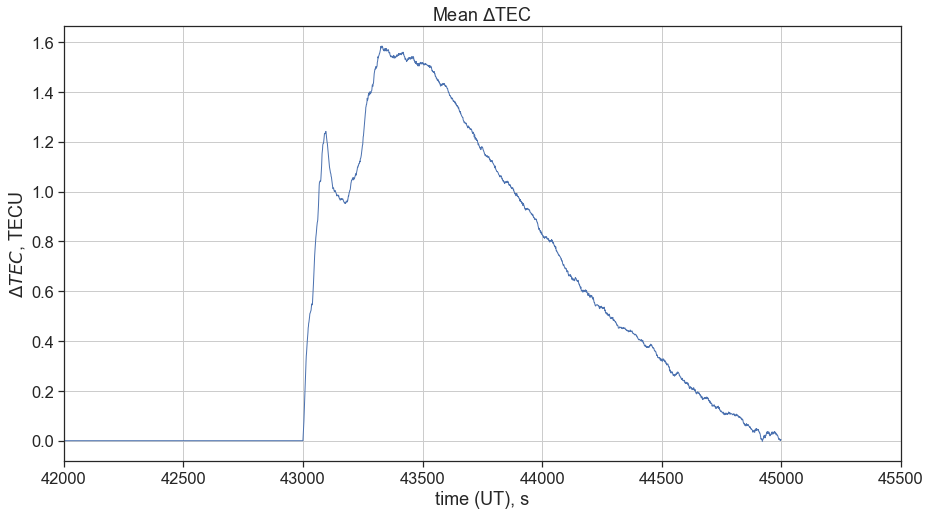

In [17]:
mean_delta_tec = np.sum(results, axis=0) / 5
ti = np.arange(t_start, t_end)

plt.figure(figsize=(15, 8))
plt.plot(ti, mean_delta_tec, linewidth=1)
plt.xlim(t_start, t_end+500)
plt.title(r'Mean $\Delta$TEC')
plt.ylabel(r'$\Delta TEC$, TECU')
plt.xlabel('time (UT), s')
plt.grid()

## Поток рентгеновского излучения во время вспышки 06.09.2017

In [18]:
directory = './data_xray_2017/'
filename = 'g15_xrs_2s_20170906_20170906.nc'

xray_data = netcdf.NetCDFFile(directory+filename, 'r')

In [19]:
bf = xray_data.variables['B_FLUX'][:]
t = xray_data.variables['time_tag'][:]
t_1 = (t - np.min(t)) / 1000

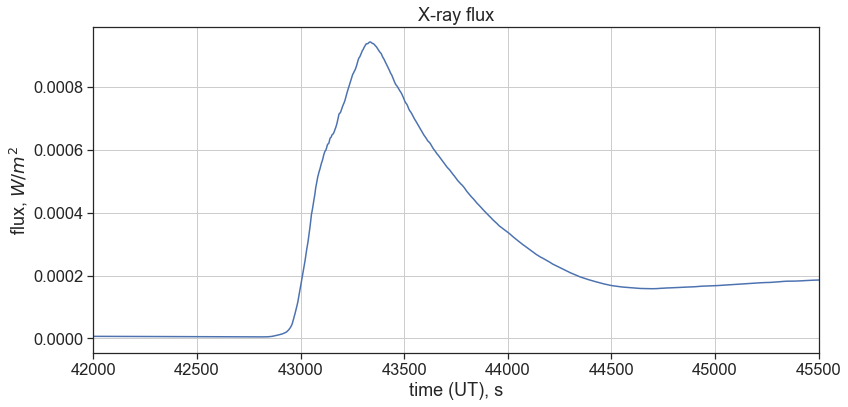

In [20]:
plt.figure(figsize=(13, 6))

plt.plot(t_1, bf)
plt.xlabel('time (UT), s')
plt.ylabel(r'flux, $W/m^2$')
plt.title('X-ray flux')
plt.xlim(t_start, t_end+500)

plt.grid()

**Сопоставление приращения ПЭС c потоком рентгена**

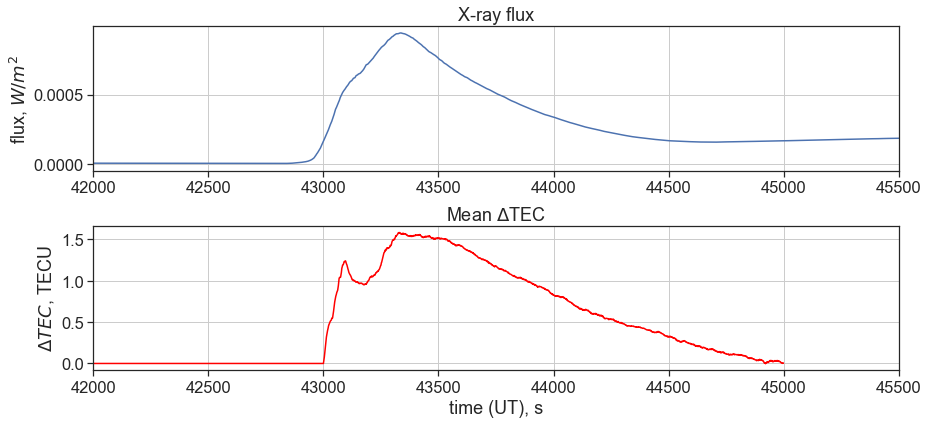

In [21]:
plt.figure(figsize=(13, 6))

plt.subplot(2, 1, 1)
plt.plot(t_1, bf)
plt.xlim(t_start, t_end+500)
plt.ylabel(r'flux, $W/m^2$')
plt.title('X-ray flux')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(ti, mean_delta_tec, color='red')
plt.xlim(t_start, t_end+500)
plt.title(r'Mean $\Delta$TEC')
plt.ylabel(r'$\Delta TEC$, TECU')
plt.xlabel('time (UT), s')
plt.grid()

plt.tight_layout()

## Высотные профили нейтралов

In [22]:
path_2 = './data_height_profiles/'
filename = '/data.mat'

data_2 = loadmat(path_2 + filename)

In [23]:
conditions = pd.DataFrame(data_2['Conditions'])
conditions

,0,1,2,3,4,5,6,7,8,9
0,2004.0,8.0,3.0,7.0,56.0,17.809053,83.743843,20.289310,NaN,3.0
1,2004.0,8.0,3.0,15.0,12.0,8.906730,158.529861,143.843002,NaN,0.0
2,2004.0,8.0,3.0,16.0,53.0,2.969144,132.584564,148.586533,NaN,0.0
3,2004.0,8.0,3.0,19.0,28.0,23.738419,-90.297546,20.093258,NaN,0.0
4,2004.0,8.0,3.0,20.0,4.0,25.219446,88.214554,129.637878,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
95662,2017.0,1.0,1.0,18.0,20.0,-28.180552,-64.717110,27.035311,70.3,7.0
95663,2017.0,1.0,1.0,18.0,21.0,-26.700346,-65.114517,26.715939,70.3,7.0
95664,2017.0,1.0,1.0,19.0,16.0,4.453685,97.445908,149.079193,70.3,7.0
95665,2017.0,1.0,1.0,23.0,44.0,68.899780,-171.957016,91.867645,70.3,6.0


In [24]:
data_2['description']

array([[array(['Conditions:'], dtype='<U11')],
       [array(['1 столбец - год'], dtype='<U15')],
       [array(['2 столбец - месяц'], dtype='<U17')],
       [array(['3 столбец - день'], dtype='<U16')],
       [array(['4 столбец - час'], dtype='<U15')],
       [array(['5 столбец - минута'], dtype='<U18')],
       [array(['6 столбец - широта'], dtype='<U18')],
       [array(['7 столбец - долгота'], dtype='<U19')],
       [array(['8 столбец - SZA'], dtype='<U15')],
       [array(['9 столбец - индекс F10.7'], dtype='<U24')],
       [array(['10 столбец - индекс Ap'], dtype='<U22')],
       [array(['-'], dtype='<U1')],
       [array(['Temperature:'], dtype='<U12')],
       [array(['Высотный профиль температуры с 50 до 90 км с шагом 5 км, [К]'],
      dtype='<U60')],
       [array(['-'], dtype='<U1')],
       [array(['Pressure:'], dtype='<U9')],
       [array(['Высотный профиль давления с 50 до 90 км с шагом 5 км, [Па]'],
      dtype='<U58')]], dtype=object)

In [25]:
from height_profile_measurements import height_profile

In [26]:
P_mean, T_mean = height_profile(data_2, months_nums=[9])

In [27]:
k = 1.38e-23
M = (P_mean / (k * T_mean)) * 1e-6

M_N2 = 0.78084 * M
M_O2 = 0.20946 * M

h = np.arange(50, 95, 5)

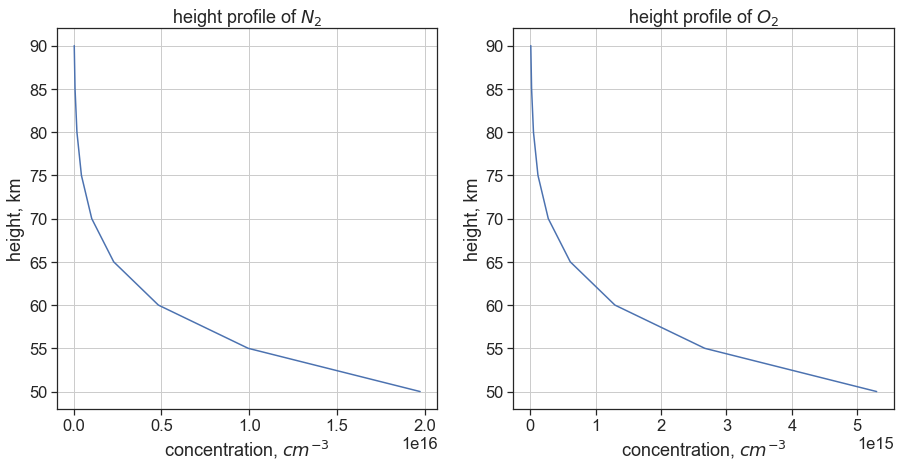

In [28]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(M_N2, h)

plt.title(r'height profile of $N_2$')
plt.xlabel(r'concentration, $cm^{-3}$')
plt.ylabel('height, km')
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(M_O2, h)

plt.title(r'height profile of $O_2$')
plt.xlabel(r'concentration, $cm^{-3}$')
plt.ylabel('height, km')
plt.grid()

In [29]:
results = np.vstack((P_mean, T_mean, M_N2, M_O2))

cols = ['h = 50 km', 'h = 55 km', 'h = 60 km', 'h = 65 km', 'h = 70 km', 'h = 75 km', 'h = 80 km', 'h = 85 km', 'h = 90 km']
rows = ['P, Pa', 'T, K', 'N_N2, cm^-3', 'N_O2, cm^-3']

pd.DataFrame(results, index=rows, columns=cols)

,h = 50 km,h = 55 km,h = 60 km,h = 65 km,h = 70 km,h = 75 km,h = 80 km,h = 85 km,h = 90 km
"P, Pa",8.583983e+01,4.448994e+01,2.220749e+01,1.066401e+01,4.827479e+00,2.055430e+00,8.401229e-01,3.370218e-01,1.329646e-01
"T, K",2.459793e+02,2.530878e+02,2.603421e+02,2.645951e+02,2.658425e+02,2.643235e+02,2.585421e+02,2.501180e+02,2.425944e+02
"N_N2, cm^-3",1.974573e+16,9.946576e+15,4.826564e+15,2.280455e+15,1.027493e+15,4.399970e+14,1.838631e+14,7.624230e+13,3.101261e+13
"N_O2, cm^-3",5.296784e+15,2.668165e+15,1.294724e+15,6.117311e+14,2.756246e+14,1.180290e+14,4.932119e+13,2.045197e+13,8.319120e+12


По этим результатам были рассчитаны высотные профили концентраций электронов

### TEC в D-области 

In [30]:
path = './data_electron_concentrations_2017/'
filename = '/Ne4_55_38_06092017_ad2.55_1.0.mat'

data_3 = loadmat(path + filename)

In [31]:
O_2 = data_3['O2']
Ne = data_3['Ne_4']
pd.DataFrame(Ne)

,0,1,2,3,4,5,6,7,8
0,14.810134,17.331747,19.783725,22.033604,37.625478,131.187126,407.070949,2820.570728,7884.041511
1,14.810172,17.331821,19.783804,22.026039,37.602258,131.332482,407.152139,2820.783869,7892.739883
2,14.810210,17.331906,19.783979,22.029705,37.637144,131.666837,408.504159,2826.554111,7916.446998
3,14.810250,17.332008,19.784315,22.033561,37.693797,132.178517,411.098483,2837.718001,7952.117190
4,14.810287,17.332096,19.784529,22.034900,37.744735,132.581007,412.295727,2844.469991,7984.887403
...,...,...,...,...,...,...,...,...,...
608,14.811475,17.333464,19.764003,21.756597,23.045043,26.404276,34.623123,61.696950,375.701415
609,14.811457,17.333368,19.763661,21.746850,23.039479,26.373110,34.541322,61.452440,372.826328
610,14.811440,17.333276,19.763329,21.754449,23.034009,26.342155,34.459753,61.210093,369.990594
611,14.811423,17.333185,19.763006,21.744762,23.028626,26.311360,34.378727,60.970193,367.193288


In [32]:
hours = O_2[:, 0]
minutes = O_2[:, 1]

t = (hours * 3600) + (minutes * 60)

Считаем TEC по определению - интегрируем $N_e$

In [33]:
n = len(t)
tec = np.zeros(n)

for i in range(n):
    s = 0
    for j in range(8):
        s += ((Ne[i, j] + Ne[i, j+1]) / 2) * 5000 * 1e6
    tec[i] = s

tecu = tec * 1e-16

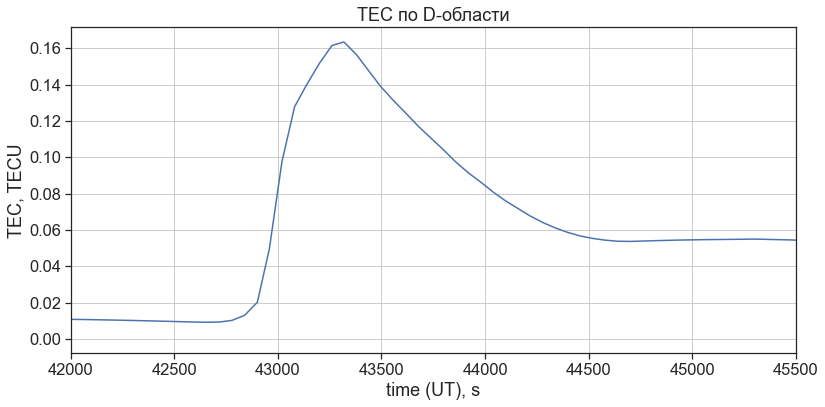

In [34]:
plt.figure(figsize=(13, 6))

plt.plot(t, tecu)
plt.xlabel('time (UT), s')
plt.ylabel('TEC, TECU')
plt.xlim(t_start, t_end+500)
plt.title('TEC по D-области')
plt.grid()

## Результаты

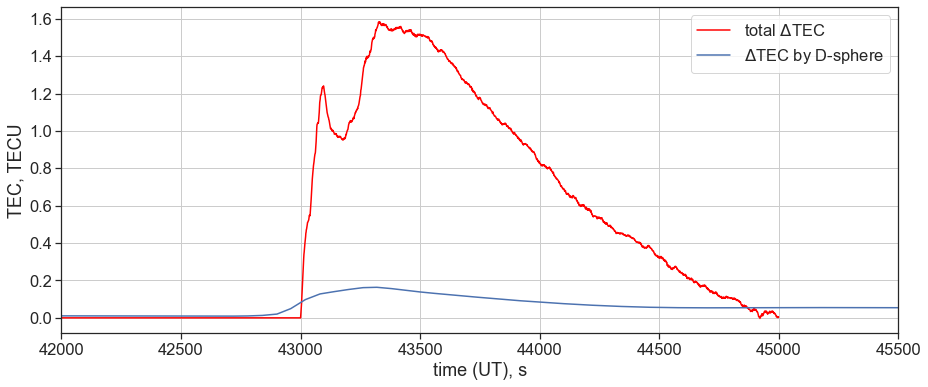

In [35]:
plt.figure(figsize=(15, 6))

plt.plot(ti, mean_delta_tec, color='red', label=r'total $\Delta$TEC')
plt.plot(t, tecu, label=r'$\Delta$TEC by D-sphere')

plt.xlim(t_start, t_end+500)
plt.xlabel('time (UT), s')
plt.ylabel('TEC, TECU')
plt.legend()
plt.grid()

Этот же график в относительных величинах

In [36]:
np.any(np.isnan(mean_delta_tec))

True

In [37]:
maximum = np.nanmax(mean_delta_tec)
mean_delta_tec_1 = mean_delta_tec / maximum
tecu_1 = tecu / maximum

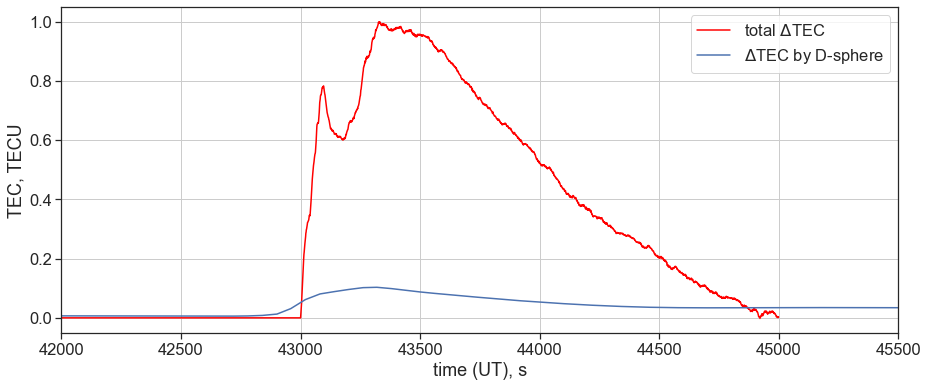

In [38]:
plt.figure(figsize=(15, 6))

plt.plot(ti, mean_delta_tec_1, color='red', label=r'total $\Delta$TEC')
plt.plot(t, tecu_1, label=r'$\Delta$TEC by D-sphere')

plt.xlim(t_start, t_end+500)
plt.xlabel('time (UT), s')
plt.ylabel('TEC, TECU')
plt.legend()
plt.grid()

**Итог:** для вспышки 06.09.2017 вклад D-области в полное электронное содержание составил 11% в пике потока рентгеновского излучения